# Universidad de Buenos Aires
# Deep Learning - TP1
# Mayo 2024

El TP comienza al momento de recibir este correo y la ventana de entrega estará abierta hasta el Domingo 16 de Junio. La resolución es individual. Pueden utilizar los contenidos vistos en clase y otra bibliografía. Si se toman ideas de fuentes externas deben ser correctamente citas incluyendo el correspondiente link o página de libro.

El formato de entrega debe ser un “link a un colab” (compartir a las siguientes direcciones: maxit1992@gmail.com, alfonsorafel93@gmail.com y lelectronfou@gmail.com). Tanto los resultados, como el código y las explicaciones deben quedar guardados y visualizables en el colab. El colab debe poder ser ejecutado sin errores.



## Ejercicio 1

**Dado el grafo de cómputo de la imagen siguiente, donde a=1, b=2 y c=3:**

1. Realizar el paso forward y calcular Y.

2. Realizar el paso backward y calcular el backpropagation para a,b y c:

    a. En forma analítica (dy/dx = 0)

    b. Utilizando pytorch

    c. Comparar los resultados de los puntos anteriores

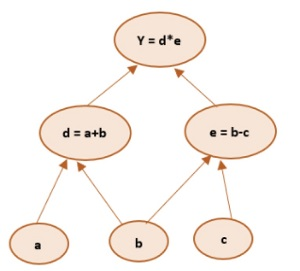

### Solucion ejercicio 1


**Paso forward**  
$$
\begin{gathered}
d=a+b\\
d=1+2\\
d=3\\
\\
e=b-c\\
e=2-3\\
e=-1\\
\\
Y=d \cdot e\\
Y=3 \cdot (-1)\\
Y=-3\\
\end{gathered}
$$

**Paso backward - Forma analitica**
  
Primero calculamos las derivadas parciales con respecto a *a*, *b* y *c*. Para esto tambien necesitamos calcular las derivadas parciales con respecto a *d* y *e*.

$$
\begin{gathered}
\frac{\partial Y}{\partial e} = \frac{\partial {(d \cdot e)}}{\partial e}\\
\frac{\partial Y}{\partial e} = d\\
\frac{\partial Y}{\partial e} = 3\\
\\
\frac{\partial Y}{\partial d} = \frac{\partial {(d \cdot e)}}{\partial d}\\
\frac{\partial Y}{\partial d} = e\\
\frac{\partial Y}{\partial d} = -1\\
\\
\frac{\partial e}{\partial c} = \frac{\partial {(b-c)}}{\partial c}\\
\frac{\partial e}{\partial c} = -1\\
\\
\frac{\partial e}{\partial b} = \frac{\partial {(b-c)}}{\partial c}\\
\frac{\partial e}{\partial b} = 1\\
\\
\frac{\partial d}{\partial b} = \frac{\partial {(a+b)}}{\partial c}\\
\frac{\partial d}{\partial b} = 1\\
\\
\frac{\partial d}{\partial a} = \frac{\partial {(a+b)}}{\partial c}\\
\frac{\partial d}{\partial a} = 1\\
\end{gathered}
$$

Por regla de la cadena, podemos calcular las derivadas parciales de *Y* con respecto a *a*, *b* y *c*.

$$
\begin{gathered}
\frac{\partial Y}{\partial c} = \frac{\partial Y}{\partial e} \cdot \frac{\partial e}{\partial c}\\
\frac{\partial Y}{\partial c} = 3 \cdot (-1)\\
\frac{\partial Y}{\partial c} = -3\\
\\
\frac{\partial Y}{\partial b} = \frac{\partial Y}{\partial d} \cdot \frac{\partial d}{\partial b} + \frac{\partial Y}{\partial e} \cdot \frac{\partial e}{\partial b}\\
\frac{\partial Y}{\partial b} = (-1) \cdot 1 + 3 \cdot 1\\
\frac{\partial Y}{\partial b} = 2\\
\\
\frac{\partial Y}{\partial a} = \frac{\partial Y}{\partial d} \cdot \frac{\partial d}{\partial a}\\
\frac{\partial Y}{\partial a} = (-1) \cdot 1\\
\frac{\partial Y}{\partial a} = -1\\
\end{gathered}
$$

**Paso backward - Pytorch**

In [263]:
import torch

In [264]:
a = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(2.0, requires_grad=True)
c = torch.tensor(3.0, requires_grad=True)

# Paso forward
d = a + b
e = b - c
Y = d * e

# Paso backward
Y.backward()

# Resultados
print(f'dY/da: {a.grad}')
print(f'dY/db: {b.grad}')
print(f'dY/dc: {c.grad}')


dY/da: -1.0
dY/db: 2.0
dY/dc: -3.0


## Ejercicio 2

Se desea construir un sistema de recomendación de películas. Para esto se cuenta con un dataset de las puntuaciones que los usuarios han asignado a las peliculas disponibles.

Link dataset: https://drive.google.com/file/d/1Og9H-8oqb3_Wo_WOakeAuRR_mwr922Ar/view?usp=sharing

Para verificar la factibilidad del proyecto con datos válidos, se decide utilizar solamente las 200 películas con más votos y los usuarios que han puntuado al menos 100 películas.

1- Analizar el dataset para utilizar solamente las 200 películas con mayor cantidad de votos y los usuarios que hayan votado al menos 100 películas.

2- A partir del dataset del punto 1, construir una única red neuronal que utilice una capa de embeddings para el id de usuario, una capa de embeddings para el id de película y al menos dos capas lineales que sea capaz de predecir el puntaje que cada usuario colocó a cada pelicula.

3- Elegir un usuario al azar, una película que dicho usuario haya puntuado y verificar la predicción del modelo. Comparar con el puntaje real que el usuario asignó a dicha película.

4- Realizar una recomendación de película para el usuario del punto 3 utilizando los embeddings de usuario o los embeddings de películas. Comprobar si la recomendación es correcta haciendo una predicción del puntuaje con la red neuronal.

### Solucion ejercicio 2


#### Parte 1

Comenzamos por importar librerias y cargar el dataset.

In [370]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

df = pd.read_csv('https://drive.google.com/uc?id=1Og9H-8oqb3_Wo_WOakeAuRR_mwr922Ar')

Reducimos el tamaño y aumentamos la confiabilidad del dataset, segun los parametros especificados:
 - Utilizar solamente las 200 peliculas que mas votos tienen
 - Utilizar solamente los usuarios que han puntuado al menos 100 peliculas

Adicionalmente vamos a remover la columna timestamp que no aporta al modelo.

In [371]:
# Remover columna timestamp
df = df.drop(['timestamp'], axis = 1)

# Filtrar usuarios que han puntuado al menos 100 peliculas
user_rating_counts = df.groupby('userId').size()
users_with_100_ratings = user_rating_counts[user_rating_counts >= 100].index
df = df[df['userId'].isin(users_with_100_ratings)]

# Filtrar las 200 peliculas con mas votos
movie_rating_counts = df.groupby('movieId').size()
top_200_movies = movie_rating_counts.nlargest(200).index
df = df[df['movieId'].isin(top_200_movies)]

#### Parte 2

Construimos un modelo con las siguientes caracteristicas:
 - El embedding de usuarios será de 8 parametros.
 - El embedding de peliculas será de 8 parametros.
 - La primera capa de embeddings es de 16 (8+8) neuronas con salida ReLU.
 - La segunda capa es de 64 neuronas con salida ReLU.
 - La tercera capa es de 32 neuronas.

In [398]:
class MovieRatingPredictor(nn.Module):
    def __init__(self, num_users, num_movies, user_embedding_dim=8, movie_embedding_dim=8, hidden_dim=64):
        super(MovieRatingPredictor, self).__init__()
        self.user_embedding = nn.Embedding(num_users, user_embedding_dim)
        self.movie_embedding = nn.Embedding(num_movies, movie_embedding_dim)
        self.fc1 = nn.Linear(user_embedding_dim + movie_embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, user_id, movie_id):
        user_embedded = self.user_embedding(user_id)
        movie_embedded = self.movie_embedding(movie_id)
        x = torch.cat([user_embedded, movie_embedded], dim=1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

Necesitamos modificar los usuarios y peliculas, ya que los embeddings esperan que los valores vayan desde [0, embeddings - 1], pero hay usuarios y peliculas con IDs fuera de esos valores.

In [379]:
unique_users = df['userId'].unique()
unique_movies = df['movieId'].unique()
print('Unique users: \n')
print(unique_users)
print('Unique movies: \n')
print(unique_movies)

Unique users: 

[  1   4   6   7  10  15  17  18  19  20  21  22  23  24  27  28  32  33
  39  40  41  42  43  45  47  50  51  52  57  58  59  62  63  64  66  68
  73  74  76  80  82  83  84  89  91  95 100 103 104 105 109 111 113 115
 117 119 122 125 129 132 135 136 137 139 140 141 144 153 156 160 166 167
 169 177 181 182 184 186 187 195 198 199 200 201 202 210 212 216 217 219
 220 221 222 226 230 232 233 234 239 240 246 247 249 254 256 260 263 265
 266 268 274 275 279 280 282 286 287 288 290 292 294 298 301 304 305 306
 307 308 309 312 313 314 317 318 322 325 326 328 330 331 332 334 339 346
 351 352 354 356 357 362 365 367 368 369 372 373 376 377 380 381 382 385
 387 391 393 405 408 409 410 411 412 414 419 420 424 425 428 432 434 436
 437 438 448 452 453 462 464 465 466 469 474 475 477 479 480 482 483 484
 488 489 490 492 495 509 510 514 517 520 522 524 525 527 534 542 551 552
 555 559 560 561 562 563 564 567 570 571 572 573 577 580 586 587 590 593
 594 596 597 599 600 601 602 603 60

Para eso entonces tenemos que mapear los valores reindexados a los valores originales y viceversa.

In [393]:
# Guardar los IDs originales
original_user_ids = df['userId'].unique()
original_movie_ids = df['movieId'].unique()

# Crear mapeo de userId y movieId a nuevos IDs
user_id_map = {original_id: index for index, original_id in enumerate(original_user_ids)}
movie_id_map = {original_id: index for index, original_id in enumerate(original_movie_ids)}

# Reindexar userId y movieId en el DataFrame original
reindexed_df = df.copy()
reindexed_df['userId'] = df['userId'].map(user_id_map)
reindexed_df['movieId'] = df['movieId'].map(movie_id_map)

# Crear la función inversa del mapeo
reverse_user_id_map = {index: original_id for original_id, index in user_id_map.items()}
reverse_movie_id_map = {index: original_id for original_id, index in movie_id_map.items()}


Dividimos el dataset en train y test para monitorear el entrenamiento del modelo y evitar overfitting.

In [381]:
train_df, test_df = train_test_split(reindexed_df, test_size=0.2, random_state=42)

Ya teniendo los mapas, podemos crear el modelo, convertir los datos a tensores PyTorch y crear el DataLoader.

In [416]:
# Crear el modelo
model = MovieRatingPredictor(len(unique_users), len(unique_movies))
model.to(device)

# Convertir los datos a tensores
train_user_ids = torch.tensor(train_df['userId'].values, dtype=torch.long, device=device)
test_user_ids = torch.tensor(test_df['userId'].values, dtype=torch.long, device=device)
train_movie_ids = torch.tensor(train_df['movieId'].values, dtype=torch.long, device=device)
test_movie_ids = torch.tensor(test_df['movieId'].values, dtype=torch.long, device=device)
train_ratings = torch.tensor(train_df['rating'].values, dtype=torch.float32, device=device)
test_ratings = torch.tensor(test_df['rating'].values, dtype=torch.float32, device=device)

# Crear el TensorDataset y DataLoader
train_dataset = TensorDataset(train_user_ids, train_movie_ids, train_ratings)
test_dataset = TensorDataset(test_user_ids, test_movie_ids, test_ratings)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Finalizando el proceso del modelo, cerramos con su entrenamiento. Definimos una funcion de perdida (MSE), un optimizador (ADAM) y una cantidad de epocas para entrenarlo (300).

In [417]:
# Definir el optimizador y la función de perdida
criterion = nn.MSELoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Guardar la perdida del modelo en una variable
global_loss = []

# Entrenar el modelo
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for user_id, movie_id, rating in train_dataloader:
        optimizer.zero_grad()
        outputs = model(user_id, movie_id).squeeze()
        loss = criterion(outputs, rating)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_dataloader)

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for user_id, movie_id, rating in test_dataloader:
            outputs = model(user_id, movie_id).squeeze()
            loss = criterion(outputs, rating)
            test_loss += loss.item()
    avg_test_loss = test_loss / len(test_dataloader)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss}, Test Loss: {avg_test_loss}')
    global_loss.append((avg_train_loss, avg_test_loss))

Epoch 1/100, Train Loss: 4.857936260558791, Test Loss: 1.3030917331323786
Epoch 2/100, Train Loss: 2.3573245315228477, Test Loss: 1.1400453367475736
Epoch 3/100, Train Loss: 2.0864851358583416, Test Loss: 1.054726359197649
Epoch 4/100, Train Loss: 1.8968757512205738, Test Loss: 0.998724765696768
Epoch 5/100, Train Loss: 1.7850852745064234, Test Loss: 0.9181299462156781
Epoch 6/100, Train Loss: 1.6372050178253044, Test Loss: 0.8975947388147903
Epoch 7/100, Train Loss: 1.5603259614968703, Test Loss: 0.8736029964382366
Epoch 8/100, Train Loss: 1.4751493054426323, Test Loss: 0.8930110446477341
Epoch 9/100, Train Loss: 1.386336298312171, Test Loss: 0.8730264013096437
Epoch 10/100, Train Loss: 1.3593452269748105, Test Loss: 0.8654782903396477
Epoch 11/100, Train Loss: 1.2946263632531894, Test Loss: 0.8388691478866642
Epoch 12/100, Train Loss: 1.2715306817475012, Test Loss: 0.866575020854756
Epoch 13/100, Train Loss: 1.2291669623326447, Test Loss: 0.8111849139302464
Epoch 14/100, Train Loss: 

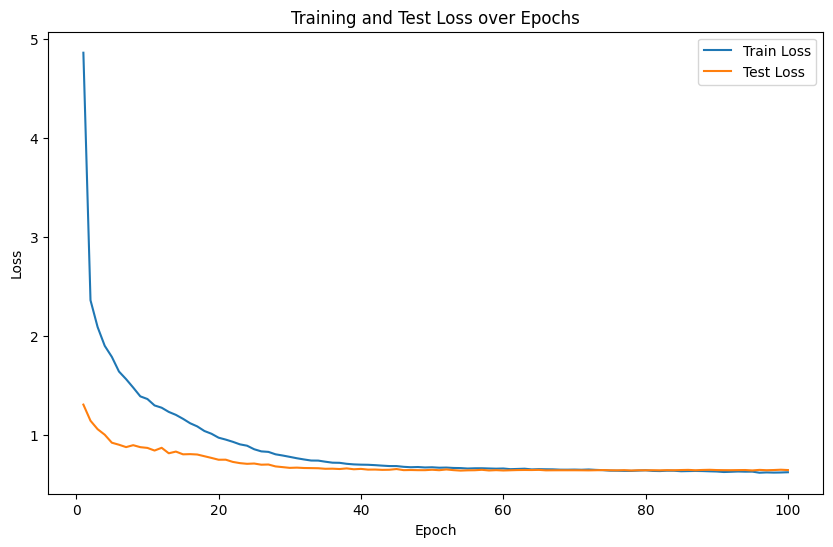

In [418]:
# Graficar la pérdida a lo largo de las epochs
train_losses, test_losses = zip(*global_loss)
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, num_epochs + 1), y=train_losses, label='Train Loss')
sns.lineplot(x=range(1, num_epochs + 1), y=test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend()
plt.show()

#### Parte 3

Con el modelo ya entrenado, es facil realizar predicciones (recomendaciones) a un usuario: se selecciona un usuario al azar y una pelicula que ese usuario haya puntuado (para poder comparar la prediccion con la realidad).

In [496]:
def predict_rating(data, user_id=None, movie_id=None):
    # Seleccionar un usuario aleatorio si no se suministra
    if user_id is None:
        user_id = random.choice(data['userId'].unique())
    # Seleccionar una película aleatoria si no se suministra
    if movie_id is None:
        movie_id = random.choice(data['movieId'].unique())
        
    # Check if the user has rated the movie
    actual_rating = data[(data['userId'] == user_id) & (data['movieId'] == movie_id)]['rating']
    if not actual_rating.empty:
        actual_rating = actual_rating.values[0]
    else:
        actual_rating = None
    
    # Get the predicted rating from the model
    model.eval()
    with torch.no_grad():
        user_tensor = torch.tensor([user_id], dtype=torch.long, device=device)
        movie_tensor = torch.tensor([movie_id], dtype=torch.long, device=device)
        predicted_rating = model(user_tensor, movie_tensor).item()
        predicted_rating = min(predicted_rating, 5.0)
    
    print(f"User ID: {reverse_user_id_map[user_id]}")
    print(f"Movie ID: {reverse_movie_id_map[movie_id]}")
    print(f"Actual Rating: {actual_rating}")
    print(f"Predicted Rating: {predicted_rating:.1f}")
    
    # Return the results
    return {
        'real_user_id': reverse_user_id_map[user_id],
        'real_movie_id': reverse_movie_id_map[movie_id],
        'actual_rating': actual_rating,
        'predicted_rating': predicted_rating
    }

In [447]:
# Elegir un usuario al azar
random_user_id = random.choice(reindexed_df['userId'].unique())

# Recomendar una película
prediction = predict_rating(reindexed_df, user_id=random_user_id)

User ID: 448
Movie ID: 377
Actual Rating: 4.0
Predicted Rating: 3.0


#### Parte 4

Para hacer una predicción, disponemos de dos opciones:

1. Buscar un usuario similar al seleccionado, y recomendarle la película mejor puntuada de ese usuario.
2. Buscar una película similar a las mejores puntuadas por el usuario seleccionado y recomendarla.

Ambos metodos requieren que se busque similitud entre embeddings: en la primera opción buscamos embeddings de usuarios similares y en la segunda opción buscamos embeddings de películas similares. El metodo que utilizaré para medir esta similitud es la similitud del coseno (https://es.wikipedia.org/wiki/Similitud_coseno), el cual estó implementado en pytorch (https://pytorch.org/docs/stable/generated/torch.nn.CosineSimilarity.html).

##### Metodo 1 de recomendación: por embedding de usuario

In [515]:
# Elegir un usuario al azar
random_user_id = random.choice(reindexed_df['userId'].unique())

# Obtener el embedding del usuario seleccionado al azar y los embeddings de todos los usuarios
user_embeddings = model.user_embedding.weight.data
random_user_embedding = model.user_embedding.weight.data[random_user_id]

# Calcular la similitud coseno entre el embedding del usuario seleccionado y todos los embeddings de usuarios
cosine_similarity = nn.CosineSimilarity()
similarities = cosine_similarity(user_embeddings, random_user_embedding)

# Establecer la similitud del usuario consigo mismo a -1 para evitar auto-recomendación
similarities[random_user_id] = -1

# Encontrar el índice del usuario más similar
most_similar_user = similarities.argmax().item()
print(f'El usuario más similar al usuario {reverse_user_id_map[random_user_id]} \
es el usuario {reverse_user_id_map[most_similar_user]} \
(similitud de {100 * similarities[most_similar_user]:.2f}%).\n')

# Encontrar las peliculas evaluadas por el usuario mas similar
most_similar_user_rated_movies = reindexed_df[reindexed_df['userId'] == most_similar_user]
most_similar_user_top_5_rated_movies = most_similar_user_rated_movies.sort_values(by='rating', ascending=False).head(5)
most_similar_user_top_5_rated_movies = most_similar_user_top_5_rated_movies.reset_index(drop=True)

print(f"Basandonos en el usuario más similar, se recomienda que la persona vea la película {reverse_movie_id_map[most_similar_user_top_5_rated_movies['movieId'][0]]}.")
print(f"En caso de ya haberla visto, puede ver \
{reverse_movie_id_map[most_similar_user_top_5_rated_movies['movieId'][1]]}, \
{reverse_movie_id_map[most_similar_user_top_5_rated_movies['movieId'][2]]}, \
{reverse_movie_id_map[most_similar_user_top_5_rated_movies['movieId'][3]]} o \
{reverse_movie_id_map[most_similar_user_top_5_rated_movies['movieId'][4]]}.\
\n")

prediction = predict_rating(reindexed_df, user_id=random_user_id, movie_id=most_similar_user_top_5_rated_movies['movieId'][0])

El usuario más similar al usuario 279 es el usuario 322 (similitud de 89.86%).

Basandonos en el usuario más similar, se recomienda que la persona vea la película 296.
En caso de ya haberla visto, puede ver 1136, 1080, 912 o 608.

User ID: 279
Movie ID: 296
Actual Rating: 5.0
Predicted Rating: 3.9


##### Metodo 2 de recomendación: por embedding de película

In [549]:
# Elegir un usuario al azar
random_user_id = random.choice(reindexed_df['userId'].unique())

# Obtener el embedding de la película con mayor rating del usuario seleccionado al azar
user_ratings = reindexed_df[reindexed_df['userId'] == random_user_id]
movie_embeddings = model.movie_embedding.weight.data
highest_rated_movie_id = user_ratings.loc[user_ratings['rating'].idxmax()]['movieId']
highest_rated_movie_rating = user_ratings.loc[user_ratings['rating'].idxmax()]['rating']
highest_rated_movie_embedding = movie_embeddings[int(highest_rated_movie_id)]

# Calcular la similitud coseno entre el embedding de la película con mayor rating del usuario seleccionado y todos los embeddings de las peliculas
cosine_similarity = nn.CosineSimilarity()
similarities = cosine_similarity(movie_embeddings, highest_rated_movie_embedding)

# Establecer la similitud de la película con mayor rating del usuario seleccionado consigo misma a -1 para evitar auto-recomendación
similarities[int(highest_rated_movie_id)] = -1

# Encontrar la película más similar a la de mejor rating del usuario seleccionado
most_similar_movie = similarities.argmax().item()
print(f"El usuario {reverse_user_id_map[random_user_id]}, \
cuya pelicula con mayor rating fue {reverse_movie_id_map[highest_rated_movie_id]} \
con puntaje de {highest_rated_movie_rating}, \
deberia ver la pelicula {reverse_movie_id_map[most_similar_movie]}, \
que es la mas parecida (similitud de {100*similarities[most_similar_movie]:.2f}%).\
\n")

prediction = predict_rating(reindexed_df, user_id=random_user_id, movie_id=most_similar_movie)

El usuario 286, cuya pelicula con mayor rating fue 47 con puntaje de 5.0, deberia ver la pelicula 8961, que es la mas parecida (similitud de 84.71%).

User ID: 286
Movie ID: 8961
Actual Rating: 4.0
Predicted Rating: 3.9
